**To Do:** 

1) Repair Time Distribution
2) Repair Counter -> Higher -> Spoil more often (Upgrade vs Repair)
3) ~~Resupply~~
4) Substitute weibull for conditional forest
5) ~~Wrappers - Monitor + Normalize~~
6) Max Resources and Duration
7) ~~Convert to Box~~
8) ~~Save vec_env~~
9) ~~Sampling~~
10) Demand
11) Fault Types
12) Backlog Cost
13) Real World Applications

In [1]:
# Import Modules
import numpy as np
from reliability.Distributions import Weibull_Distribution

class Train:

    def __init__(self, alpha, 
                 beta, repair_cost):

        self.working = 1

        # Cost elements
        self.repair_cost = repair_cost

        self.age = 0
        self.repair_counter = 0
        self.repair_time = 0
        self.repair_status = 0

        # Survival
        self.reliability_dist = Weibull_Distribution(alpha=alpha, beta=beta)
        self.ttf = np.round(self.reliability_dist.random_samples(1)) # Time to failure

    # Deterioration
    def failure_check(self):

        if self.working:
            self.age += 1

        # Break down
        if self.age >= self.ttf:
            self.working = 0
            return
            
    def repair(self):

        self.ttf = np.round(self.reliability_dist.random_samples(1)) # Time to failure
        self.age = 0
        
        self.repair_time = 1
        self.repair_counter += 1
        self.working = 1
        self.repair_status = 1

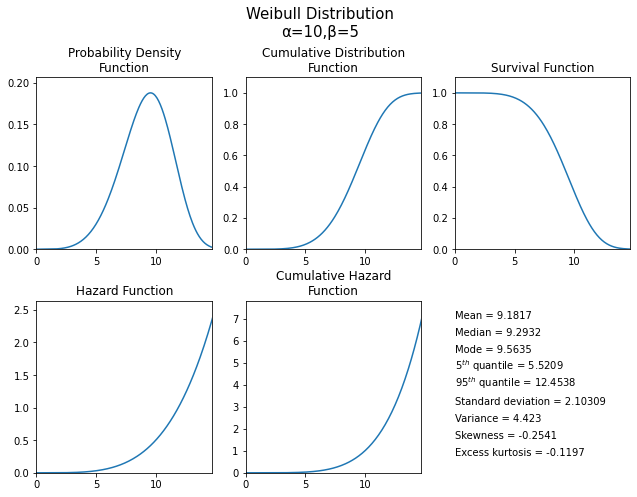

In [2]:
from reliability.Distributions import Weibull_Distribution

reliability_dist = Weibull_Distribution(alpha=10, beta=5)
reliability_dist.plot()

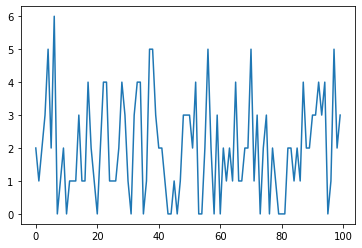

In [3]:
import matplotlib.pyplot as plt

plt.plot(np.random.poisson(2, 100))

In [4]:
import gym
from gym import spaces
import time
import numpy as np
import pandas as pd
# from gym_pm.envs.Objects import Train
from IPython.display import display, clear_output

class Rail_Env(gym.Env):
    metadata = {"render.modes": ["console"]}

    def __init__(self, env_config=None, 
                 alpha=10, beta=5, 
                 repair_cost=30):

        # Cost elements
        self.repair_cost = repair_cost

        # Initialize everything
        self.alpha = alpha
        self.beta = beta
        self.reset()

        # Episode length
        self.max_duration = 3000 # max time

        # action space
        self.action_space = spaces.Discrete(2)
        # obs space
        self.observation_space = spaces.Dict({
                "age": spaces.Box(low=0., high=self.max_duration, shape=(1,), dtype=np.float32),
                "Failure": spaces.MultiBinary(1)
                })

    def reset(self):

        # reset timer
        self.timer = 0

        self.machine = Train(alpha=self.alpha,
                             beta=self.beta,
                             repair_cost=self.repair_cost)

        return self.observation()

    def observation(self):

        state = {
            "age": [self.machine.age],
            "Failure": [-(self.machine.working - 1)]
        }

        state = {i: np.array(j, dtype='float32') for (i, j) in state.items()}

        return state

    def get_reward(self):

        reward = 0.
        if self.machine.repair_status == False:
            reward += 100
        # Repair Cost
        reward -= self.machine.repair_cost * self.machine.repair_status * self.machine.repair_time
        if self.machine.working == False:
            reward -= 200

        return reward

    def check_done(self):

        if self.timer >= self.max_duration:
            done = True
        else:
            done = False

        return done

    def step(self, action):

        # Reset Repair Status
        self.machine.repair_status = 0

        # Deterioriation
        self.machine.failure_check()

        # Interactions (Add more as desired)
        if action == 0:
            self.machine.repair()
        else:
            pass

        obs = self.observation()
        reward = self.get_reward()
        done = self.check_done()
        info = {}

        self.timer += 1

        return obs, reward, done, info

    def render(self, mode="console"):

        result = pd.Series({i: j[0] for (i, j) in self.observation().items()})

        result['age'] = result['age'].astype(int)
        result.Failure = result.Failure.astype(bool)
        result['ttf'] = self.machine.ttf[0]
        result['repair_count'] = self.machine.repair_counter
        result['reward'] = self.get_reward()
        result['duration'] = int(self.timer)
        result = result.to_frame('Results')
            
        if mode == 'human':

            clear_output(wait=True)
            display(result)
            time.sleep(1)

        return result

    def close(self):
        pass

# Test Environment

In [5]:
from stable_baselines3.common.env_checker import check_env

env = Rail_Env()
check_env(env, warn=True)

In [6]:
env.reset()
for _ in range(5):
    env.render('human')
    env.step(env.action_space.sample()) # take a random action

    if env.check_done():
        break

,Results
age,4
Failure,False
ttf,9
repair_count,0
reward,100
duration,4
